In [1]:
import basket_util
from basket_util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import collections

import plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

from pySankey.sankey import sankey

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
init_notebook_mode(connected=True)


* use print(basket_util.__doc__) to get the doc string

In [2]:
dropna = True
datecol = 'placed_at'
#filename = 'new_baskets_full.csv'
filename = 'new_baskets_adhie.csv'

baskets = prep_data(filename, dropna,datecol)
merchant_attributes = get_merchant_attributes(baskets)


In [3]:
merchant_topcat = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values=['order_id', 'qty', 'spent'], # Column to aggregate for values
    aggfunc={'order_id': 'nunique', 'qty':sum, 'spent':sum},  # Aggregation function
    fill_value= 0,
)
merchant_topcat.columns = [f'{x}_{y}' for x,y in merchant_topcat.columns]


In [4]:
df0 = (merchant_attributes
    .query('tenure_month <=1'))
df1 = (merchant_attributes
    .query('tenure_month > 1 and last_month <= 19')
) # churner
df2 = (merchant_attributes
    .query('tenure_month > 1 and last_month > 19')
) # non-churner
churn_label = pd.concat([pd.DataFrame(zip(df0['merchant_id'], [1] * len(df0)), columns = ['merchant_id', 'churn']),
        pd.DataFrame(zip(df1['merchant_id'], [1] * len(df1)), columns = ['merchant_id', 'churn']),
        pd.DataFrame(zip(df2['merchant_id'], [0] * len(df2)), columns = ['merchant_id', 'churn'])], axis=0)
churn_label = churn_label.set_index(keys='merchant_id')
#df0.merchant_id.nunique() , df1.merchant_id.nunique(), df2.merchant_id.nunique(), df0.merchant_id.nunique() + df1.merchant_id.nunique()+ df2.merchant_id.nunique()

In [5]:
merchant_attributes = merchant_attributes.set_index(keys='merchant_id')
merchant_attributes = pd.merge(merchant_attributes, merchant_topcat, on="merchant_id")
df_churn = pd.merge(churn_label, merchant_attributes, on = "merchant_id")

In [10]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion= "entropy", random_state=0)
clf = clf.fit(merchant_attributes, churn_label)
cross_val_score(clf, merchant_attributes, churn_label, cv=10)

array([0.48484848, 0.78787879, 0.54545455, 0.81818182, 0.75757576,
       0.87878788, 0.78787879, 0.72727273, 0.63636364, 0.65625   ])

[Text(0.6619718309859155, 0.9666666666666667, 'X[2] <= 9.5\nentropy = 0.922\nsamples = 329\nvalue = [218, 111]'),
 Text(0.6338028169014085, 0.9, 'entropy = 0.0\nsamples = 59\nvalue = [0, 59]'),
 Text(0.6901408450704225, 0.9, 'X[2] <= 10.5\nentropy = 0.707\nsamples = 270\nvalue = [218, 52]'),
 Text(0.5070422535211268, 0.8333333333333334, 'X[7] <= 361.5\nentropy = 0.896\nsamples = 141\nvalue = [97, 44]'),
 Text(0.43661971830985913, 0.7666666666666667, 'X[80] <= 67.5\nentropy = 0.815\nsamples = 115\nvalue = [86, 29]'),
 Text(0.4084507042253521, 0.7, 'X[60] <= 88.5\nentropy = 0.872\nsamples = 99\nvalue = [70, 29]'),
 Text(0.352112676056338, 0.6333333333333333, 'X[115] <= 999500.0\nentropy = 0.816\nsamples = 91\nvalue = [68, 23]'),
 Text(0.323943661971831, 0.5666666666666667, 'X[57] <= 3.5\nentropy = 0.884\nsamples = 76\nvalue = [53, 23]'),
 Text(0.29577464788732394, 0.5, 'X[105] <= 131250.0\nentropy = 0.833\nsamples = 72\nvalue = [53, 19]'),
 Text(0.22535211267605634, 0.43333333333333335, 

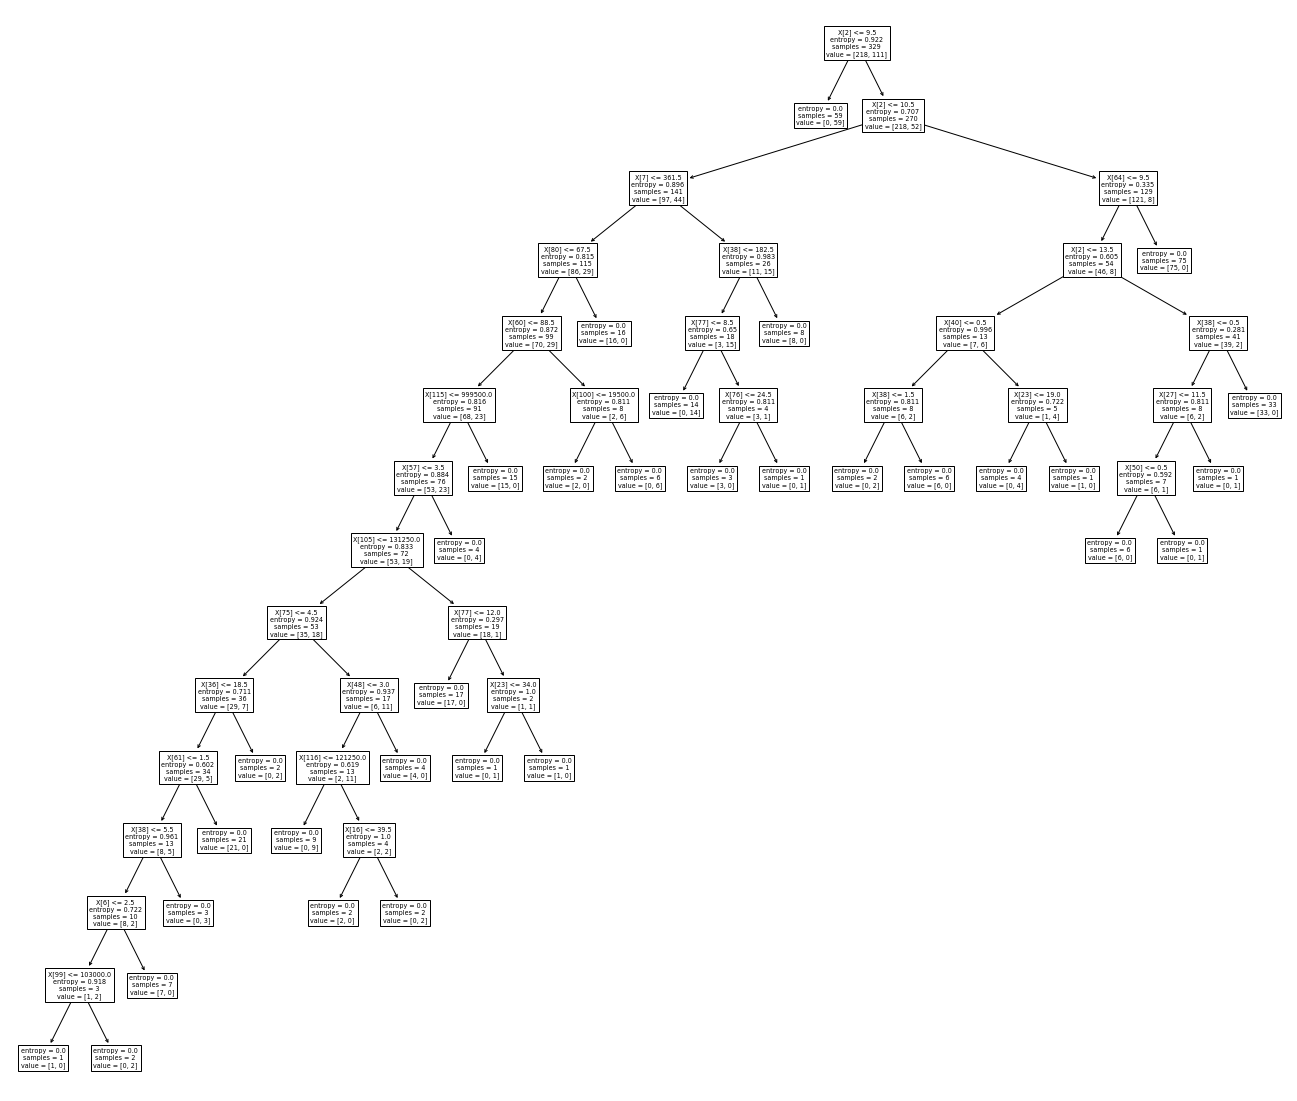

In [11]:
plt.figure(figsize=(23, 20))  
tree.plot_tree(clf)


In [ ]:
clf.predict_proba(merchant_attributes)

In [ ]:
for i,(j,k) in enumerate(clf.predict_proba(merchant_attributes)):
    print(j)

### now df_churn is ready to be used for training a supervised learning model

In [ ]:
for s in merchant_attributes.columns:
    print(s)

In [15]:
np.random.seed(0)
merchant_attributes.reset_index(drop=True)
churn_label.reset_index(drop=True)
indices = np.random.permutation(len(merchant_attributes))

In [16]:
np.random.seed(0)
merchant_attributes.reset_index(drop=True)
churn_label.reset_index(drop=True)
indices = np.random.permutation(len(merchant_attributes))
df_churn_x_train = merchant_attributes.iloc[indices[:-10]]
df_churn_y_train = churn_label.iloc[indices[:-10]]
df_churn_x_test = merchant_attributes.iloc[indices[-10:]]
df_churn_y_test = churn_label.iloc[indices[-10:]]
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(p=1)
knn.fit(df_churn_x_train, df_churn_y_train)
#KNeighborsClassifier()


KNeighborsClassifier(p=1)

In [17]:
print(knn.predict_proba(df_churn_x_test))

[[0.4 0.6]
 [0.6 0.4]
 [0.8 0.2]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.8 0.2]
 [0.8 0.2]]


In [18]:
knn.predict(df_churn_x_test),df_churn_y_test

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              churn
 merchant_id       
 234              0
 143              0
 223              1
 123              0
 196              0
 315              0
 120              0
 14               0
 73               1
 94               0)

In [3]:
df = (merchant_attributes
    #.query('last_month < 20')
    .groupby(['first_month','last_month'])
    ['merchant_id']
    .agg('nunique')
    .reset_index()
)
df[df['first_month']==df['last_month']].merchant_id.sum()

24

In [4]:
(merchant_attributes
    .query('first_month == last_month and last_month < 16')
    ['merchant_id']
    .nunique()) #/ merchant_attributes.shape[0]

11

In [13]:
sku_attributes = get_sku_attributes(baskets)
order_attributes = get_order_attributes(baskets)

sku_by_day = get_skus_by_day(baskets)
top_cats = make_top_cats(baskets)

,churn,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
merchant_id,,,,,,,,,,,,,
6,1,1195500.0,2,10,10,1,2,2,19,7,9,5.977500e+05,1
7,1,18300.0,1,11,11,1,1,1,1,1,1,1.830000e+04,1
8,1,96000.0,1,11,11,1,1,1,1,1,1,9.600000e+04,1
34,1,2756500.0,2,10,10,1,1,2,15,4,5,1.378250e+06,1
138,1,16931500.0,2,10,10,1,1,2,26,11,11,8.465750e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0,11531000.0,9,20,21,2,5,9,50,13,17,1.281222e+06,2
317,0,83309500.0,22,20,21,2,7,21,138,18,31,3.786795e+06,2
318,0,96731900.0,39,20,21,2,6,36,197,24,54,2.480305e+06,2


In [20]:
df_churn

,churn,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,...,spent_26,spent_27,spent_28,spent_29,spent_30,spent_31,spent_32,spent_33,spent_34,spent_35
merchant_id,,,,,,,,,,,,,,,,,,,,,
6,1,1195500.0,2,10,10,1,2,2,19,7,...,0,785000,0,94000,0,0,0.0,0,0,0
7,1,18300.0,1,11,11,1,1,1,1,1,...,0,18300,0,0,0,0,0.0,0,0,0
8,1,96000.0,1,11,11,1,1,1,1,1,...,0,0,0,0,0,0,0.0,0,0,0
34,1,2756500.0,2,10,10,1,1,2,15,4,...,0,2263500,0,0,0,0,0.0,0,0,0
138,1,16931500.0,2,10,10,1,1,2,26,11,...,0,13980500,0,97000,0,0,0.0,0,1181000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0,11531000.0,9,20,21,2,5,9,50,13,...,0,0,0,913500,74000,0,445000.0,0,745000,0
317,0,83309500.0,22,20,21,2,7,21,138,18,...,401000,51693000,495000,757000,0,0,175000.0,0,2017000,50000
318,0,96731900.0,39,20,21,2,6,36,197,24,...,446000,70592600,39000,763000,0,0,277000.0,0,752500,50000


In [7]:
df1 = (merchant_attributes
    .query('tenure_month > 2')
    .query('last_month == 16')
) # churner
df2 = (merchant_attributes
    .query('tenure_month > 5')
    .query('last_month > 16')
) # non-churner
df1.merchant_id.nunique(), df2.merchant_id.nunique()

(11, 213)

In [ ]:
df = (merchants.query('last_month > 16' and 'tenure_month > 5')
    .groupby('tenure_month')
    ['merchant_id']
    .agg('nunique') # aggregate using custom function
    .reset_index()
    #.query('month_num < 18')
)
df.merchant_id.sum()

In [ ]:
df = (baskets #.query('month_num < 18')
    .groupby('merchant_id')
    ['month_num']
    .agg(max) # aggregate using custom function
    .reset_index()
    .query('month_num < 18')
)
df.shape

In [90]:
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]
baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]

df1 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='order_id', # Column to aggregate for values
    aggfunc="nunique")    # Aggregation function
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='spent', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1.fillna(0,inplace=True)
df2.fillna(0,inplace=True)

In [91]:
df1.head()

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
merchant_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,8.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,7.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,11.0,0.0,0.0,1.0,1.0,9.0,...,3.0,29.0,0.0,3.0,0.0,1.0,1.0,1.0,4.0,6.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
data_scaled = normalize(df1)
data_scaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.07955573,
        0.        ],
       [0.09166985, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02490677, ..., 0.02490677, 0.0996271 ,
        0.14944064],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10050378,
        0.10050378],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

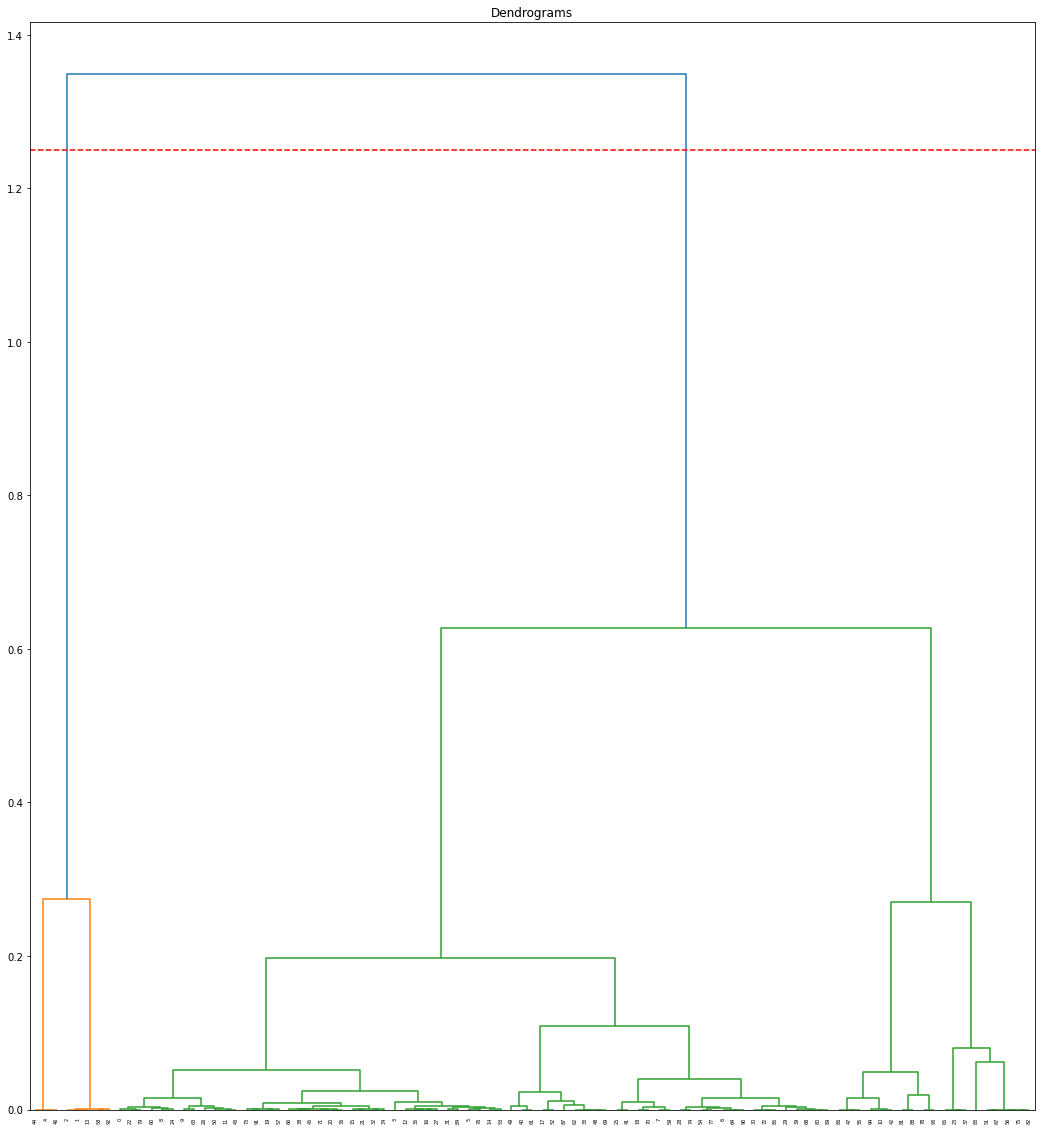

In [88]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
data_scaled = normalize(df1)
data_scaled = pd.DataFrame(data_scaled, columns=df1.columns)
#data_scaled.head()

plt.figure(figsize=(18, 20))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1.25, color='r', linestyle='--')


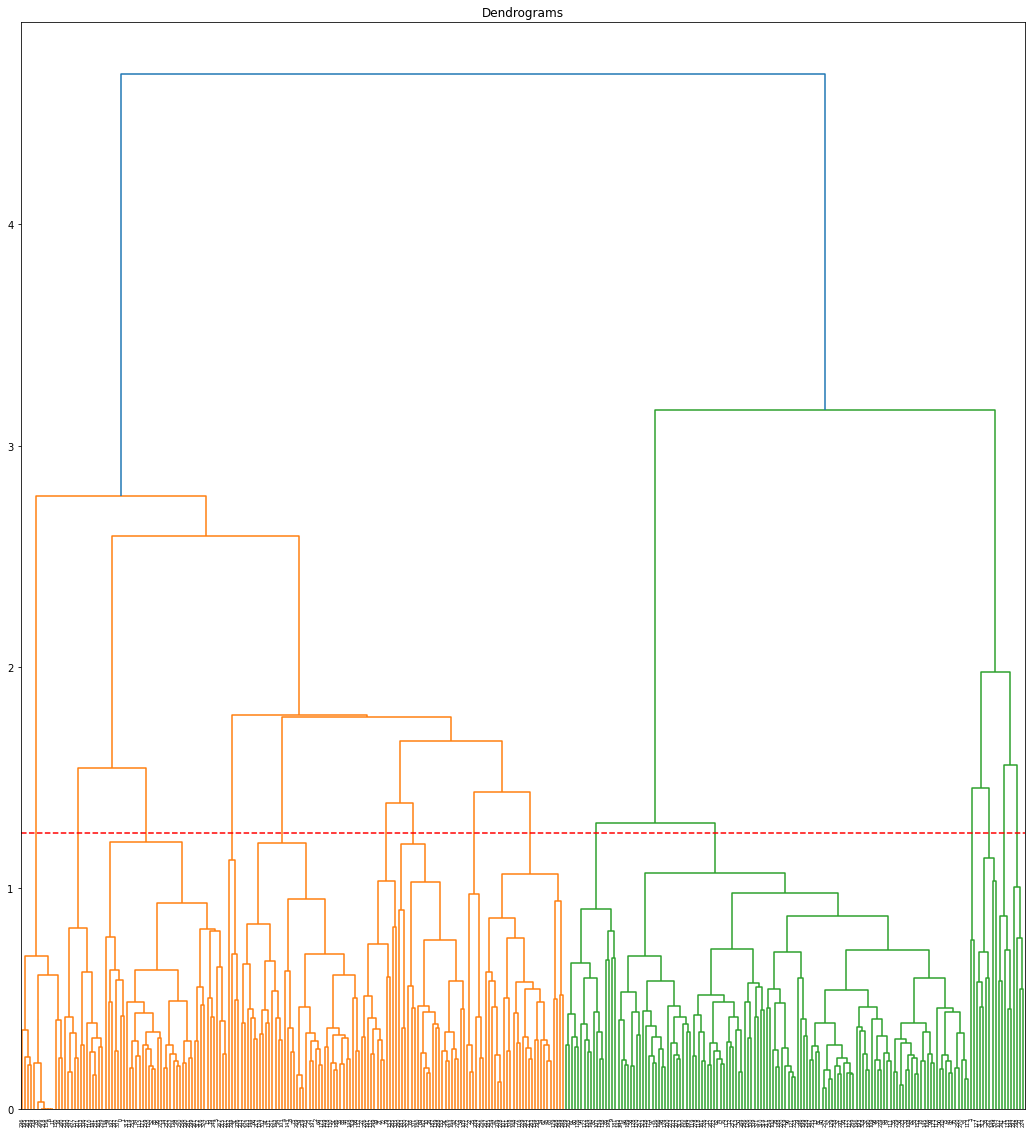

In [74]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(18, 20))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1.25, color='r', linestyle='--')


In [89]:
data_scaled.head()

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
0,7.880304e-08,0.999635,9.719042e-07,2.889445e-07,4.202829e-07,1.576061e-07,3.414798e-07,6.829597e-07,3.808814e-06,6.304243e-07,1.129510e-06,0.027017,1.576061e-07
1,1.663741e-06,0.894427,6.654964e-07,4.325727e-06,5.989468e-06,6.654964e-07,6.654964e-07,6.654964e-07,6.654964e-06,2.329237e-06,2.994734e-06,0.447214,1.996489e-06
2,4.595998e-06,0.894427,9.191996e-07,2.757599e-06,4.595998e-06,9.191996e-07,9.191996e-07,9.191996e-07,1.746479e-05,5.515198e-06,9.191996e-06,0.447214,2.297999e-06
3,3.095840e-09,1.000000,9.107397e-07,1.688640e-09,5.628799e-09,1.970080e-09,5.910239e-09,3.292848e-08,1.865947e-07,9.287519e-09,2.279664e-08,0.000309,4.221599e-09
4,1.860584e-06,0.948683,4.293656e-07,8.587312e-07,1.431219e-06,2.862437e-07,2.862437e-07,2.862437e-07,1.288097e-06,1.431219e-07,1.431219e-07,0.316228,7.156093e-07


 - big cluster (131 members) was only able to be broken down at n-cluster = 15
 - cluster number = 5 or 8 are the best at breaking down big clusters.

In [95]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
df1_results['label'] = pd.DataFrame(cluster.fit_predict(data_scaled))
df1_results.groupby('label').count()

,0
label,
0,66
1,9
2,9
3,39
4,53
5,131
6,4
7,14


,0
label,
0,109
1,9
2,9
3,14
4,53
5,131
